IMPORTING LIBRARIES

In [17]:
# Everyday data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model libraries, scaling, metrics, etc
from sklearn.preprocessing import StandardScaler

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

LOADING DATASET

In [18]:
df = pd.read_csv('Sleep_Efficiency.csv')

#Convert wakeup time to minutes as float type
df['Wakeup time'] = pd.to_datetime(df['Wakeup time'])
df['Wakeup time'] = df['Wakeup time'].dt.hour.astype(float) * 60 + df['Wakeup time'].dt.minute.astype(float) 

#Convert bedtime to minutes as float type and rescale the time if test subject goes to sleep after 12 A.M.
df['Bedtime'] = pd.to_datetime(df['Bedtime'])
df['Bedtime'] = np.where(df['Bedtime'].dt.hour.astype(float) * 60 + df['Bedtime'].dt.minute.astype(float) <= 200, \
                         df['Bedtime'].dt.hour.astype(float) * 60 +  df['Bedtime'].dt.minute.astype(float) + 1440, \
                         df['Bedtime'].dt.hour.astype(float) * 60 +  df['Bedtime'].dt.minute.astype(float))

#Convert smoking status to binary values
df['Smoking status'] = np.where(df['Smoking status'] == "Yes", 1, 0)

#Drop uninformative/unrelated columns
df = df.drop(['ID', 'Gender', 'REM sleep percentage', "Light sleep percentage", "Deep sleep percentage"], axis='columns')

#Drop NULL values
df = df.dropna()

#Move the last column to the last position
label = 'Sleep efficiency'
df[label] = df.pop(label)

#Logit transform the sleep efficiency
df["Sleep efficiency"] = np.log(df["Sleep efficiency"]/(100 - df["Sleep efficiency"]))

# Select the features to be standardized
features_to_standardize = ['Awakenings', 'Alcohol consumption', 'Exercise frequency', 'Age', 'Caffeine consumption']

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the selected features (standardization)
df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])


#Reorder the columns by its absolute correlation with the label
covariances = abs(df.corr().iloc[:-1, -1])
sorted_columns = covariances.sort_values(ascending=False).index.tolist() + ['Sleep efficiency']

df = df[sorted_columns]

df




,Awakenings,Alcohol consumption,Smoking status,Exercise frequency,Bedtime,Wakeup time,Age,Caffeine consumption,Sleep duration,Sleep efficiency
0,-1.195204,-0.712049,1,0.859132,1500.0,420.0,1.805639,-0.783159,6.0,-4.724165
1,1.020111,1.150480,1,0.859132,1560.0,540.0,2.104460,-0.783159,7.0,-5.014064
2,-0.456766,-0.712049,0,0.859132,1290.0,330.0,-0.061998,-0.783159,8.0,-4.712764
3,1.020111,2.392165,1,-0.524035,1590.0,510.0,-0.061998,0.943350,6.0,-5.273402
4,1.020111,1.150480,0,0.859132,1500.0,540.0,1.207995,-0.783159,8.0,-4.871978
...,...,...,...,...,...,...,...,...,...,...
445,1.758549,0.529637,1,-0.524035,1380.0,390.0,-0.809052,0.943350,7.5,-5.234734
447,-1.195204,-0.712049,0,2.242300,1320.0,330.0,-1.033169,-0.783159,7.5,-4.690339
448,1.758549,-0.712049,0,0.859132,1260.0,180.0,0.834468,0.080096,6.0,-4.898848
450,1.020111,-0.712049,0,0.859132,1260.0,240.0,0.311529,-0.783159,7.0,-4.871978


EXPLORATORY SOME INFORMATION ABOUT DATASET

*REM SLEEP*:

REM (Rapid Eye Movement) sleep is a distinct stage of the sleep cycle. Typically occurring approximately 90 minutes after falling asleep, the first REM period is relatively short, lasting around 10 minutes. As the sleep cycle progresses, subsequent REM stages become longer, with the final one potentially extending up to an hour. During REM sleep, heart rate and breathing become more rapid.

One remarkable aspect of REM sleep is its association with vivid dreaming, owing to heightened brain activity during this stage. REM sleep is pivotal for various reasons. It activates specific areas of the brain that are essential for learning and memory consolidation. Additionally, REM sleep is linked to increased protein production, which contributes to neurological health.

Interestingly, infants experience a substantial amount of their sleep in the REM stage, up to 50% of their total sleep duration, in contrast to adults who typically spend about 20% of their sleep cycle in REM sleep.



*DEEP SLEEP*:

While all sleep stages are vital, deep sleep holds particular significance for brain health and optimal cognitive function. This stage of sleep plays a crucial role in allowing the brain to recuperate and reenergize. It facilitates the replenishment of energy reserves and contributes to the reinforcement of declarative memory, aiding in the retention of factual information.

Moreover, deep sleep plays a pivotal role in maintaining hormonal balance. The pituitary gland secretes human growth hormone during this stage, promoting tissue growth and the regeneration of cells throughout the body.



*LIGHT SLEEP*:

As part of the sleep cycle, individuals progress through several sleep stages, one of which is light sleep. This initial stage often marks the transition from full wakefulness to deeper sleep phases. Light sleep is characterized by a relatively lower level of brain activity and muscle tone compared to deeper sleep stages. Approximately half of the total sleep duration is spent in light sleep.

In summary, the sleep cycle encompasses different stages, including REM sleep, deep sleep, and light sleep, each with its unique functions and contributions to overall sleep quality and bodily well-being.

Variances and Covariances of Features

Text(0.5, 1.0, 'Correlation')

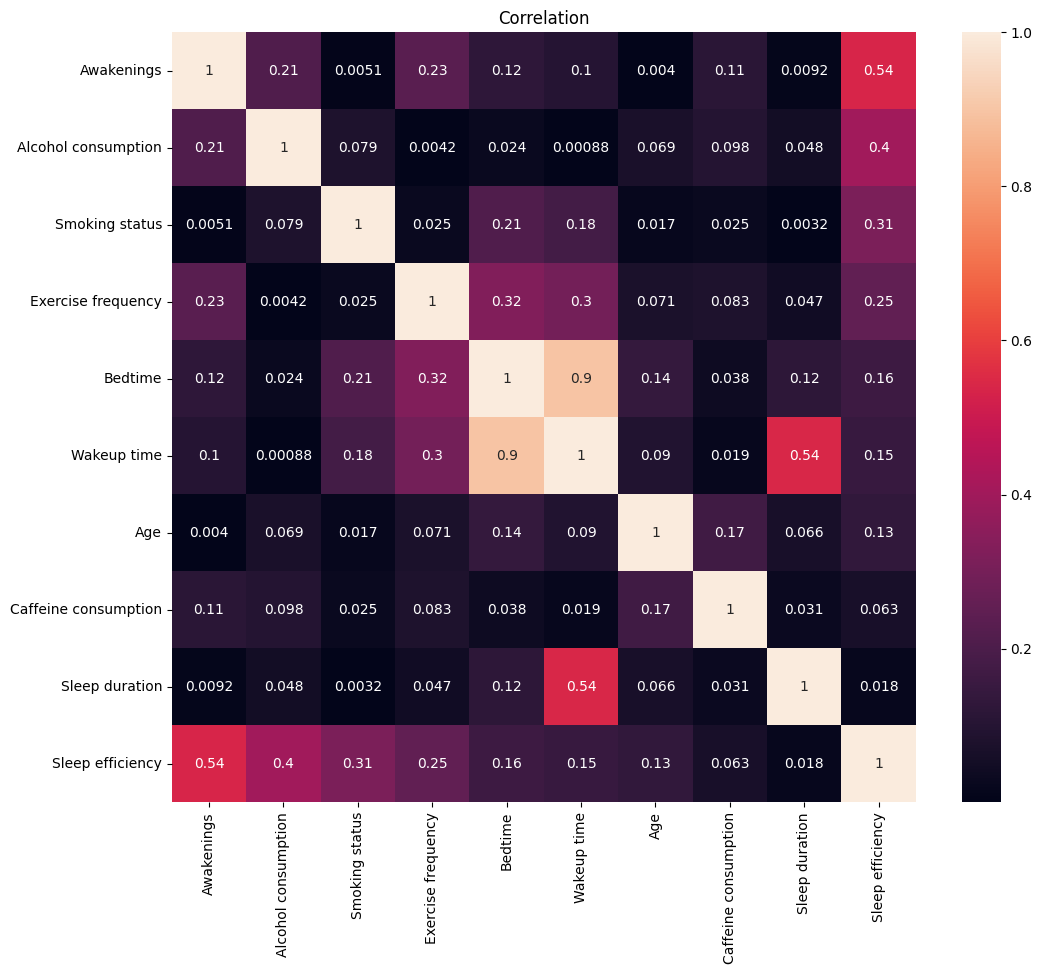

In [19]:
# visualisation of the correlations
fig = plt.figure(figsize = (12,10))

r = sns.heatmap(abs(df.corr()), annot=True)
# set title
r.set_title('Correlation')


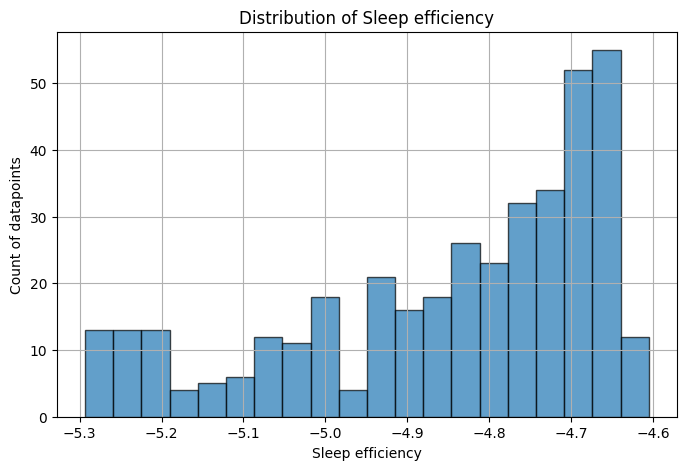

In [20]:
# Assuming 'df' contains your DataFrame with the 'Sleep efficiency' label
label_column = 'Sleep efficiency'

# Create a histogram of the label
plt.figure(figsize=(8, 5))
plt.hist(df[label_column], bins=20, edgecolor='k', alpha=0.7)
plt.title(f'Distribution of {label_column}')
plt.xlabel(label_column)
plt.ylabel('Count of datapoints')
plt.grid(True)
plt.show()

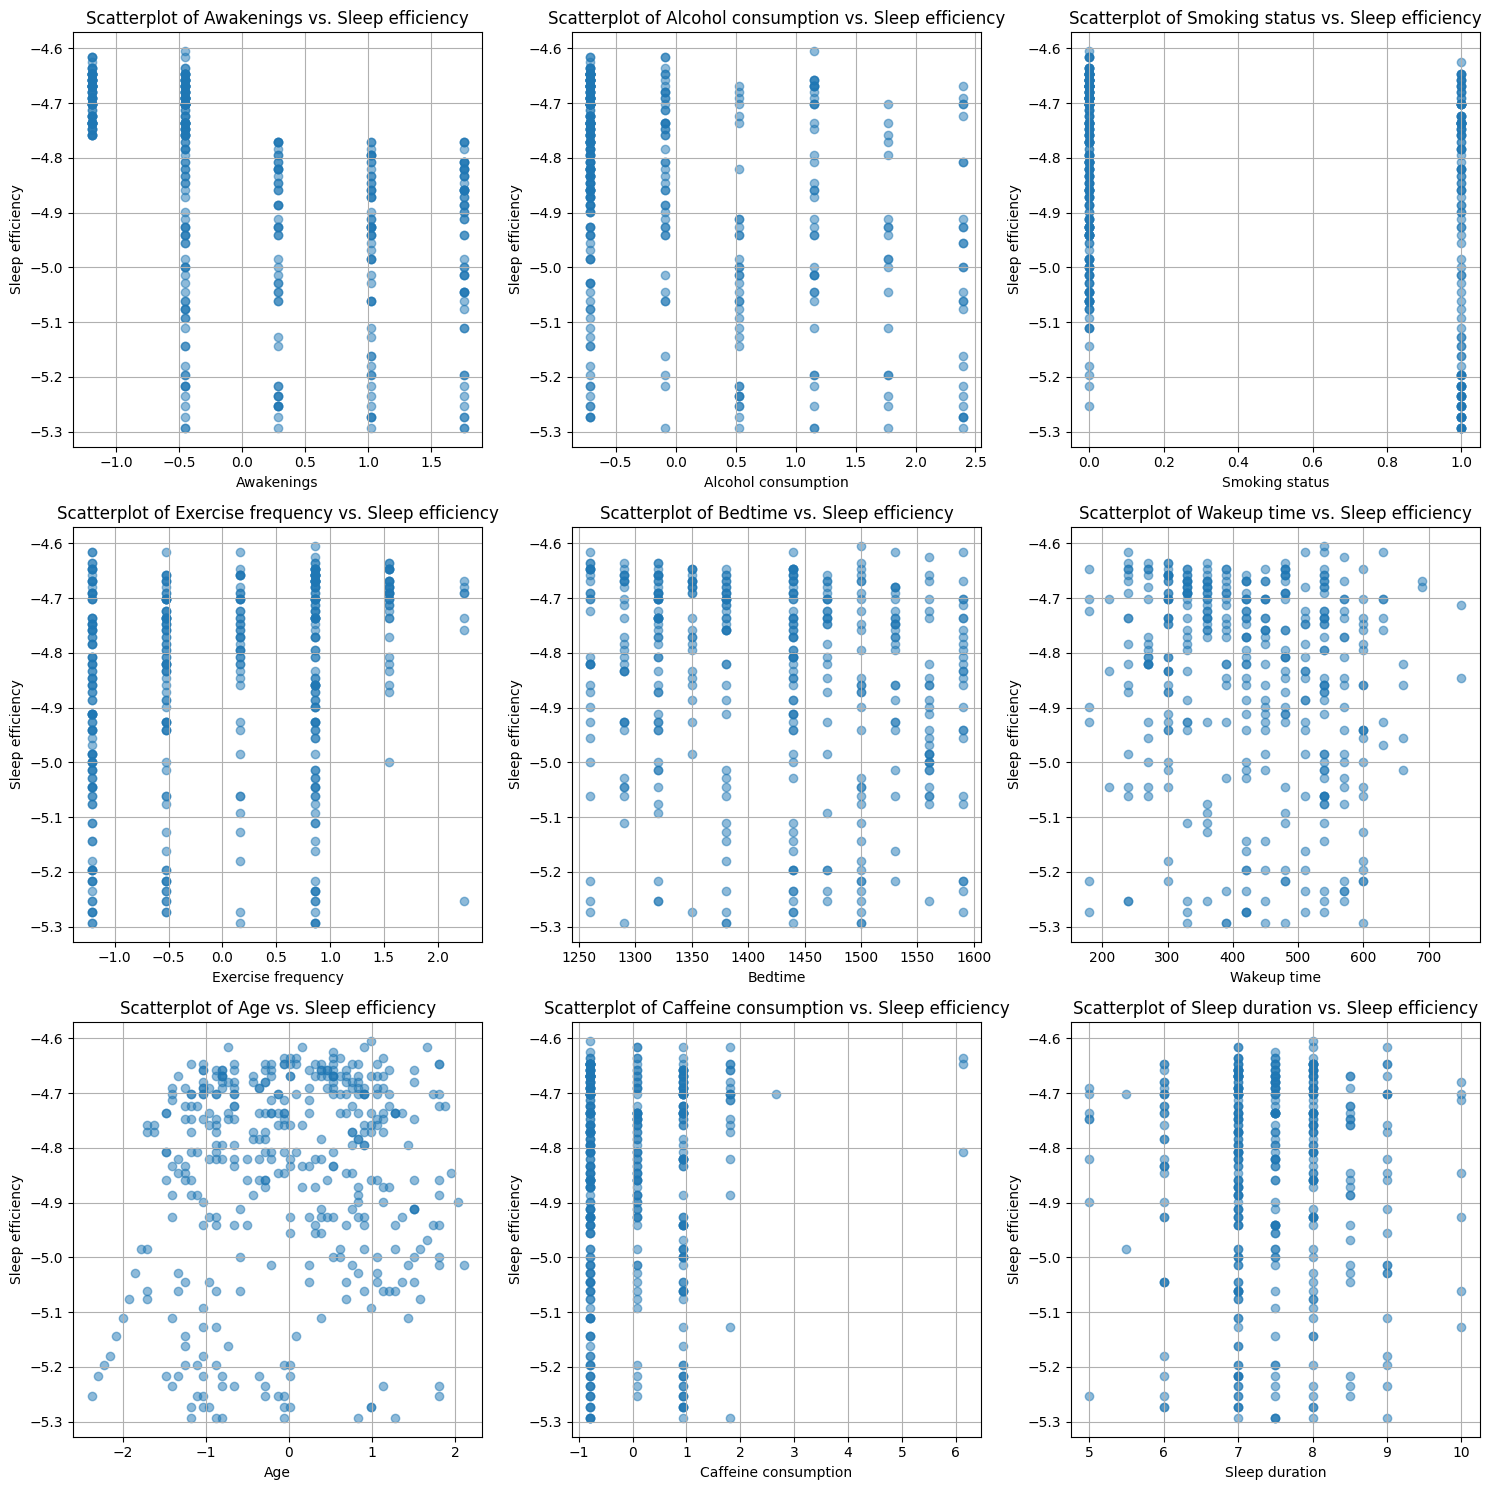

In [21]:
import matplotlib.pyplot as plt

# Assuming 'df' contains your DataFrame with the features and labels
num_features = len(df.columns) - 1  # Exclude the last column ('Sleep efficiency')

# Define the number of columns for subplots (number of features per row)
num_cols = 3  # You can change this to your preferred number of columns
num_rows = (num_features - 1) // num_cols + 1  # Calculate the number of rows

# Create subplots with the specified layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Loop through features and create scatterplots
for i, feature in enumerate(df.columns[:-1]):
    ax = axes[i]  # Get the current subplot
    ax.scatter(df[feature], df['Sleep efficiency'], alpha=0.5)
    ax.set_title(f'Scatterplot of {feature} vs. Sleep efficiency')
    ax.set_xlabel(feature)
    ax.set_ylabel('Sleep efficiency')
    ax.grid(True)

# Hide any empty subplots (if num_features is not a multiple of num_cols)
for i in range(num_features, num_cols * num_rows):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


A function fetching data to training/validation set and label set

In [22]:
#Default 388 datapoints and 9 features
def load_data(m=388, n=9):
    df = pd.read_csv('Sleep_Efficiency.csv')

    #Convert wakeup time to minutes as float type
    df['Wakeup time'] = pd.to_datetime(df['Wakeup time'])
    df['Wakeup time'] = df['Wakeup time'].dt.hour.astype(float) * 60 + df['Wakeup time'].dt.minute.astype(float) 

    #Convert bedtime to minutes as float type and rescale the time if test subject goes to sleep after 12 A.M.
    df['Bedtime'] = pd.to_datetime(df['Bedtime'])
    df['Bedtime'] = np.where(df['Bedtime'].dt.hour.astype(float) * 60 + df['Bedtime'].dt.minute.astype(float) <= 200, \
                            df['Bedtime'].dt.hour.astype(float) * 60 +  df['Bedtime'].dt.minute.astype(float) + 1440, \
                            df['Bedtime'].dt.hour.astype(float) * 60 +  df['Bedtime'].dt.minute.astype(float))


    #Convert smoking status to binary values
    df['Smoking status'] = np.where(df['Smoking status'] == "Yes", 1, 0)

    #Drop uninformative columns
    df = df.drop(['ID', 'Gender', 'REM sleep percentage', "Light sleep percentage", "Deep sleep percentage"], axis='columns')

    #Drop NULL values
    df = df.dropna()

    #Move the last column to the last position
    label = 'Sleep efficiency'
    df[label] = df.pop(label)

    #Logit transform the sleep efficiency
    df["Sleep efficiency"] = np.log(df["Sleep efficiency"]/(100 - df["Sleep efficiency"]))

    # Select the features to be standardized
    features_to_standardize = ['Awakenings', 'Alcohol consumption', 'Exercise frequency', 'Age', 'Caffeine consumption']

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Fit and transform the selected features (standardization)
    df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

    #Reorder the columns by its absolute correlation with the label
    covariances = abs(df.corr().iloc[:-1, -1])
    sorted_columns = covariances.sort_values(ascending=False).index.tolist() + ['Sleep efficiency']


    df = df[sorted_columns]
    
    X = df.iloc[:m, :n].to_numpy()
    y = df.iloc[:m, -1].to_numpy().reshape(-1)


    
    return X, y
    
X, y = load_data()


Split feature matrix to training/validation set and test set

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2)

In [24]:
n = 9 # max number of features
X, y = load_data(n=n)  # read in 20 data points with n features 

err_train = np.zeros(n)  # Array to store training errors
err_val = np.zeros(n)  # Array to store validation errors

K = 5  # Number of splits
kf = KFold(n_splits=K, shuffle=True)    # Create a KFold object with 'K' splits

for r in range(n):
    err_train_splits = []  # List for storing the training errors for the splits
    err_val_splits = []  # List for storing the validation errors for the splits
    
    X_i_features = X[:, :(r+1)]

    for train_indices, val_indices in kf.split(X_i_features):
        
        X_train = X_i_features[train_indices,:]    # Get the training set    
        X_val = X_i_features[val_indices,:]    # Get the validation set
        y_train = y[train_indices]
        y_val = y[val_indices]
        
        
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        
        pred_train = reg.predict(X_train)
        err_train_splits.append(mean_squared_error(y_train, pred_train))
        
        pred_val = reg.predict(X_val)
        err_val_splits.append(mean_squared_error(y_val, pred_val))
        
            
    err_train[r] = np.array(err_train_splits).mean()
    err_val[r] = np.array(err_val_splits).mean()   
        

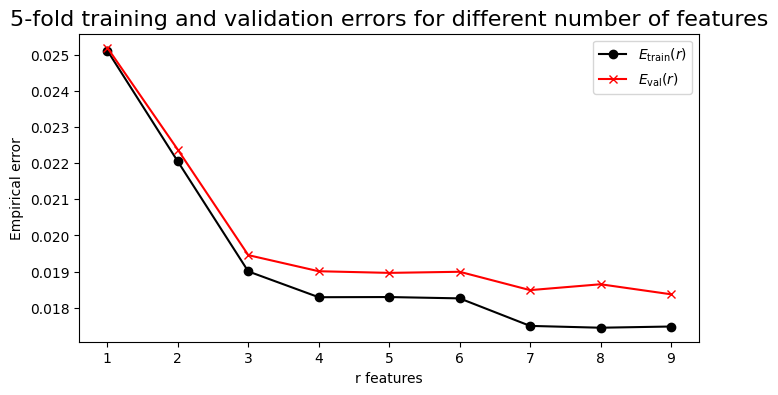

In [25]:
# Plot the training and validation errors for the different number of features r
plt.figure(figsize=(8,4))
plt.plot(range(1, n+1), err_train, color='black', label=r'$E_{\rm train}(r)$', marker='o')  # Plot training error
plt.plot(range(1, n+1), err_val, color='red', label=r'$E_{\rm val}(r)$', marker='x')  # Plot validation error

plt.title('5-fold training and validation errors for different number of features', fontsize=16)    # Set title
plt.ylabel('Empirical error')    # Set label for y-axis
plt.xlabel('r features')         # Set label for x-axis
plt.xticks(range(1, n+1))      # Set the tick labels on the x-axis to be 1,...,n
plt.legend()
plt.show()

In [26]:
# create a table to compare training and validation errors
errors = {"features":[i for i in range(1, n+1)],
          "train_errors":err_train,
          "val_errors":err_val,
         }
pd.DataFrame({ key:pd.Series(value) for key, value in errors.items()})

,features,train_errors,val_errors
0,1,0.025117,0.025198
1,2,0.022049,0.022375
2,3,0.019005,0.019456
3,4,0.018291,0.019010
4,5,0.018296,0.018965
5,6,0.018259,0.018995
6,7,0.017497,0.018487
7,8,0.017447,0.018650
8,9,0.017480,0.018372


We can conclude with reasonable confidence that the model with the best performance on new data points is the one using the first 7 features.

In [27]:
## define a list of values for the maximum polynomial degree 
degrees = [1,2,3,4]  

# we will use this variables to store the resulting training and validation errors for each polynomial degree
err_train_poly = []
err_val_poly = []

K_poly = 5  # Number of splits
kf_poly = KFold(n_splits=K_poly, shuffle=True)    # Create a KFold object with 'K' splits


for degree in degrees: 

    err_train_splits_poly = []  # List for storing the training errors for the splits
    err_val_splits_poly = []  # List for storing the validation errors for the splits


    for train_indices, val_indices in kf_poly.split(X_train_val[:,:7]):
        
        X_train_poly= X_train_val[train_indices,:]    # Get the training set    
        X_val_poly = X_train_val[val_indices,:]    # Get the validation set
        y_train_poly = y_train_val[train_indices]
        y_val_poly = y_train_val[val_indices]
        
        
        lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant item in the new feature X_poly
        poly = PolynomialFeatures(degree=degree)    # generate polynomial features
        X_train_poly = poly.fit_transform(X_train_poly)    # fit the raw features
        lin_regr.fit(X_train_poly, y_train_poly)    # apply linear regression to these new features and labels
        
        y_pred_train_poly = lin_regr.predict(X_train_poly)    # predict using the linear model
        tr_error_poly = mean_squared_error(y_train_poly, y_pred_train_poly)    # calculate the training error
        X_val_poly = poly.transform(X_val_poly) # transform the raw features for the validation data 
        y_pred_val_poly = lin_regr.predict(X_val_poly) # predict values for the validation data using the linear model 
        val_error_poly = mean_squared_error(y_val_poly, y_pred_val_poly) # calculate the validation error

        err_val_splits_poly.append(val_error_poly)
        err_train_splits_poly.append(tr_error_poly)

            
    err_train_poly.append(np.array(err_train_splits_poly).mean())
    err_val_poly.append(np.array(err_val_splits_poly).mean()) 
 
    

In [28]:
# create a table to compare training and validation errors
errors = {"poly degree":degrees,
          "linear train errors":err_train_poly,
          "linear val errors":err_val_poly,
         }
pd.DataFrame({ key:pd.Series(value) for key, value in errors.items()})

,poly degree,linear train errors,linear val errors
0,1,1.480101e-02,0.016052
1,2,8.766055e-03,0.014330
2,3,5.122441e-03,0.095143
3,4,5.751955e-07,3.372866


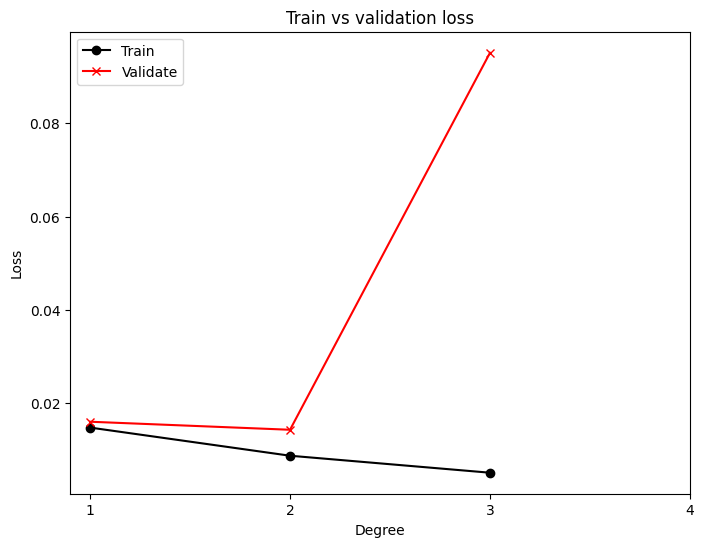

In [29]:
plt.figure(figsize=(8, 6))

plt.plot(degrees[:3], err_train_poly[:3], label = 'Train', color="black", marker="o")
plt.plot(degrees[:3], err_val_poly[:3], label = 'Validate', color="red", marker="x")
plt.xticks(degrees)
plt.legend(loc = 'upper left')

plt.xlabel('Degree')
plt.ylabel('Loss')
plt.title('Train vs validation loss')
plt.show()

In [30]:
## define a list of values for the number of hidden layers
num_layers = [6,7,8,9,10,11,12,13,14,15,16,17,18]    # number of hidden layers
num_neurons = 20  # number of neurons in each layer


# we will use this variables to store the resulting training and validation errors for each polynomial degree
err_train_mlp = []
err_val_mlp = []

K_mlp = 5  # Number of splits
kf_mlp = KFold(n_splits=K_mlp, shuffle=True)    # Create a KFold object with 'K' splits


for i, num in enumerate(num_layers):

    err_train_splits_mlp = []  # List for storing the training errors for the splits
    err_val_splits_mlp = []  # List for storing the validation errors for the splits


    for train_indices, val_indices in kf_poly.split(X_train_val[:,:7]):
        
        X_train_mlp = X_train_val[train_indices,:]    # Get the training set    
        X_val_mlp = X_train_val[val_indices,:]    # Get the validation set
        y_train_mlp = y_train_val[train_indices]
        y_val_mlp = y_train_val[val_indices]
        
        
        hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple
        
        mlp_regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=2000) # Initialise an MLPRegressor
        
    
        mlp_regr.fit(X_train_mlp, y_train_mlp)    # Train MLP on the training set
        
        
        ## evaluate the trained MLP on both training set and validation set
        y_pred_train_mlp = mlp_regr.predict(X_train_mlp)    # predict on the training set
        tr_error_mlp = mean_squared_error(y_train_mlp, y_pred_train_mlp)    # calculate the training error
        y_pred_val_mlp = mlp_regr.predict(X_val_mlp) # predict values for the validation data 
        val_error_mlp = mean_squared_error(y_val_mlp, y_pred_val_mlp) # calculate the validation error
        
        # sanity check num of layers
        assert mlp_regr.n_layers_ == num_layers[i]+2 # total layers = num of hidden layers + input layer + output layer
        # sanity check the error values


        err_val_splits_mlp.append(val_error_mlp)
        err_train_splits_mlp.append(tr_error_mlp)

            
    err_train_mlp.append(np.array(err_train_splits_mlp).mean())
    err_val_mlp.append(np.array(err_val_splits_mlp).mean()) 

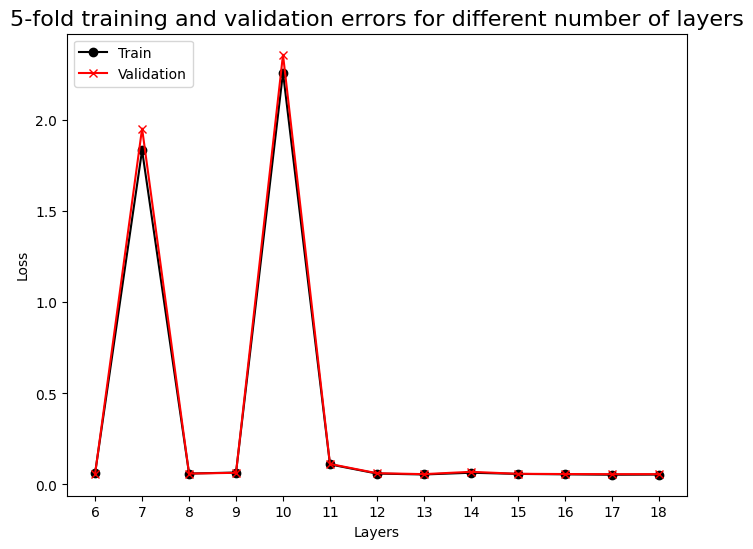

In [31]:
plt.figure(figsize=(8, 6))

plt.title('5-fold training and validation errors for different number of layers', fontsize=16)    # Set title
plt.plot(num_layers, err_train_mlp, label = 'Train', color="black", marker="o")
plt.plot(num_layers, err_val_mlp,label = 'Validation', color="red", marker="x")
plt.xticks(num_layers)
plt.legend(loc = 'upper left')

plt.xlabel('Layers')
plt.ylabel('Loss')
plt.show()

In [32]:
# create a table to compare the training and validation errors for MLPs with different number of hidden layers
errors = {"num hidden layers":num_layers,
          "mlp train errors":err_train_mlp,
          "mlp val errors":err_val_mlp,
         }
pd.DataFrame(errors)

,num hidden layers,mlp train errors,mlp val errors
0,6,0.062957,0.059371
1,7,1.835022,1.954107
2,8,0.059866,0.059730
3,9,0.065475,0.063908
4,10,2.261453,2.359468
5,11,0.110157,0.112533
6,12,0.059813,0.061742
7,13,0.054722,0.056702
8,14,0.064332,0.069349
9,15,0.057885,0.058499


In [44]:
lin_regr_final = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant item in the new feature X_poly
poly_final = PolynomialFeatures(degree=2)    # generate polynomial features
X_train_final = poly_final.fit_transform(X_train_val)    # fit the training features
lin_regr_final.fit(X_train_final, y_train_val)    # apply linear regression to these new features and labels

X_test_final = poly_final.transform(X_test)
y_pred_test_final = lin_regr_final.predict(X_test_final)
test_error_final = mean_squared_error(y_pred_test_final, y_test)

# Create a DataFrame with an index for the test error
errors = {"test error": test_error_final}
error_df = pd.DataFrame(errors, index=[0])

# Print the DataFrame
pd.DataFrame(error_df)

,test error
0,0.027326
